In [ ]:
import pandas as pd
import pydicom
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
import os

# Load the CSV file
df = pd.read_csv('RSNA_breast_cancer_data.csv')  # Adjust the path as needed

# Function to load DICOM images and resize them
def load_dicom_image(image_path, target_size=(256, 256)):
    dicom = pydicom.dcmread(image_path)
    image = dicom.pixel_array
    image_resized = cv2.resize(image, target_size)
    image_normalized = image_resized / np.max(image_resized)  # Normalize pixel values
    return np.expand_dims(image_normalized, axis=-1)  # Add a channel dimension

# Load all the images and labels
image_paths = df['image_path'].values
labels = df['cancer'].values

# Prepare data
images = []
for path in image_paths:
    image = load_dicom_image(path)  # Directly use the full path from the CSV
    images.append(image)

images = np.array(images)
labels = np.array(labels)

In [7]:
print(images.shape)

(2374, 256, 256, 1)


In [9]:
# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 50% of the remaining data

# Expand dimensions to fit the model input (Batch, Height, Width, Channels)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [20]:
del model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Build a more complex CNN model
model = Sequential([
    # Add convolutional layers with Batch Normalization
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten the output of the convolutions to feed into the dense layer
    Flatten(),

    # Add dense layers
    Dense(512, activation='relu'),
    Dropout(0.3),  # Reduce dropout rate to avoid underfitting

    # Output layer (binary classification)
    Dense(1, activation='sigmoid')])

# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,080,897 (99.49 MB)

 Trainable params: 26,079,937 (99.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [22]:
# Lists to store training and validation accuracy for each epoch
train_acc = []
val_acc = []

# Manually batching without ImageDataGenerator
batch_size = 16
epochs = 10

for epoch in range(epochs):
    # Shuffle data every epoch
    indices = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]

    # Initialize variables to accumulate training accuracy for this epoch
    correct_predictions = 0
    total_predictions = 0

    # Loop through batches
    for start in range(0, len(X_train), batch_size):
        end = min(start + batch_size, len(X_train))
        X_batch = X_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]

        # Train the model on the batch
        loss, acc = model.train_on_batch(X_batch, y_batch)

        # Update training accuracy metrics
        correct_predictions += acc * X_batch.shape[0]
        total_predictions += X_batch.shape[0]

    # Calculate average training accuracy for the epoch
    train_accuracy = correct_predictions / total_predictions
    train_acc.append(train_accuracy)

    # Evaluate on validation data at the end of each epoch
    val_loss, val_acc_epoch = model.evaluate(X_val, y_val, verbose=2)
    print(f"Epoch {epoch+1}/{epochs} - Train accuracy: {train_accuracy} - Validation accuracy: {val_acc_epoch}")

    # Store the validation accuracy for this epoch
    val_acc.append(val_acc_epoch)

8/8 - 2s - 253ms/step - accuracy: 0.5190 - loss: 14.0838
Epoch 1/10 - Train accuracy: 0.5430960059165955 - Validation accuracy: 0.5189873576164246
8/8 - 2s - 258ms/step - accuracy: 0.5190 - loss: 10.9384
Epoch 2/10 - Train accuracy: 0.5890450477600098 - Validation accuracy: 0.5189873576164246
8/8 - 2s - 240ms/step - accuracy: 0.5190 - loss: 3.7123
Epoch 3/10 - Train accuracy: 0.6243171095848083 - Validation accuracy: 0.5189873576164246
8/8 - 2s - 234ms/step - accuracy: 0.5612 - loss: 1.4947
Epoch 4/10 - Train accuracy: 0.6172066926956177 - Validation accuracy: 0.5611814260482788
8/8 - 2s - 235ms/step - accuracy: 0.5443 - loss: 1.8557
Epoch 5/10 - Train accuracy: 0.6480851173400879 - Validation accuracy: 0.5443037748336792
8/8 - 2s - 234ms/step - accuracy: 0.6329 - loss: 1.0190
Epoch 6/10 - Train accuracy: 0.6256500482559204 - Validation accuracy: 0.6329113841056824
8/8 - 2s - 239ms/step - accuracy: 0.6835 - loss: 0.7433
Epoch 7/10 - Train accuracy: 0.661548912525177 - Validation accura

In [23]:
# Evaluate on test data after training is complete
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc}")

8/8 - 2s - 244ms/step - accuracy: 0.6008 - loss: 1.2921

Test accuracy: 0.6008403301239014


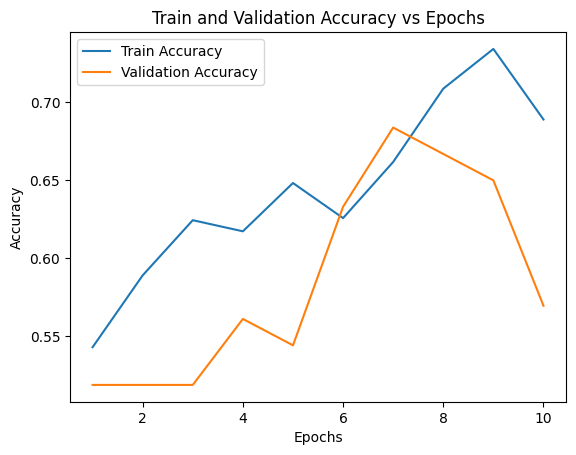

In [25]:
# Plotting the training and validation accuracy after all epochs
plt.plot(range(1, epochs + 1), train_acc, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy vs Epochs')
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step


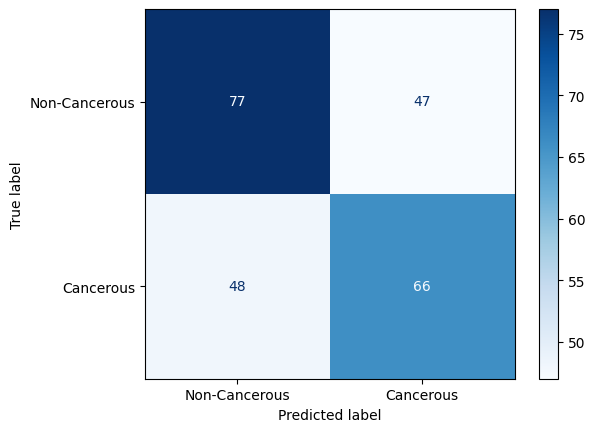

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions on the test set
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary class labels
y_pred = (y_pred_probs > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)
plt.show()